# Evaluating and Tuning a Binary Classification Model

## Goals

After this lesson, you should be able to:

- Build and explain confusion matrices from a model output
- Calculate various binary classification metrics
- Explain the AUC/ROC curve, why it matters, and how to use it
- Understand when and how to optimize a model for various metrics
- Optimize a classification model based on costs

### Category definitions - possible outcomes in binary classification
 
#### - TP = True Positive (class 1 correctly classified as class 1) - e.g. Patient with cancer tests positive for cancer
#### - TN = True Negative (class 0 correctly classified as class 0) - e.g. Patient without cancer tests negative for cancer
#### - FP = False Positive (class 0 incorrectly classified as class 1) - e.g. Patient without cancer tests positive for cancer
#### - FN = False Negative (class 1 incorrectly classified as class 0) - e.g. Patient with cancer tests negative for cancer

### $$ \text{Possible misclassifications} $$

![Type 1 vs. Type 2 Error](images/type-1-type-2.jpg)

## All the Binary Classification Metrics

![classification metrics](./images/conf_matrix_classification_metrics.png)

## Let's run a model and look at some metrics 

In [7]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

[Dataset info](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)

In [8]:
df = pd.read_csv('./data/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [9]:
df = pd.get_dummies(df, 
               columns = ['sex', 'cp', 'fbs', 'restecg', 'ca', 'slope', 'exang'], 
               drop_first= True)
print(df.shape)
df.head()

(303, 21)


,age,trestbps,chol,thalach,oldpeak,thal,target,sex_1,cp_1,cp_2,...,fbs_1,restecg_1,restecg_2,ca_1,ca_2,ca_3,ca_4,slope_1,slope_2,exang_1
0,63,145,233,150,2.3,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,37,130,250,187,3.5,2,1,1,0,1,...,0,1,0,0,0,0,0,0,0,0
2,41,130,204,172,1.4,2,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,56,120,236,178,0.8,2,1,1,1,0,...,0,1,0,0,0,0,0,0,1,0
4,57,120,354,163,0.6,2,1,0,0,0,...,0,1,0,0,0,0,0,0,1,1


In [10]:
df['target'].value_counts(normalize = True)

1    0.544554
0    0.455446
Name: target, dtype: float64

In [11]:
X = df.drop('target', axis = 1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 77, stratify = y, test_size = .2)
print('>> Train_test splited data set is: ', "\n\nX_train: {}, \nX_test: {}, \ny_train: {}, \ny_test: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

>> Train_test splited data set is:  

X_train: (242, 20), 
X_test: (61, 20), 
y_train: (242,), 
y_test: (61,)


In [12]:
## Let's check number of 1 and 0 in both datasets
print('mean', y_train.mean(), 'std', y_train.std())


mean 0.5454545454545454 std 0.49896157727991414


In [13]:
# scaling 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #.fit(X_train)
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_train_scaler.shape
## then used 
# scaler.transform(X_test)
# X_train_sca = scaler.transform(X_train).shape

(242, 20)

In [14]:
data = [[0, 0], [0, 0], [1, 1], [1, 1]]
scaler_ex = StandardScaler()
print(scaler_ex.fit(data))
print(scaler_ex.mean_)
print(scaler_ex.transform(data))
print(scaler_ex.transform([[2,2]]))
# print(scaler_ex.)

StandardScaler(copy=True, with_mean=True, with_std=True)
[0.5 0.5]
[[-1. -1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1.  1.]]
[[3. 3.]]


[Check sklearn for documentation of Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


[For solvers](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [15]:
## Let's go with the vanilla case - no regularization
lr = LogisticRegression(C = 1e9, solver = 'newton-cg', max_iter=10000)
lr.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

In [16]:
## What is this score?
print(lr.score(X_train, y_train))

0.8801652892561983


In [17]:
def cross_validation(n, shuffle=True, lr=None):
    """Cross validate logistic regression model n times."""
    cv = StratifiedKFold(n_splits=n, random_state=1019, shuffle=True)

    # vanilla cross validation
    if lr == 'vanilla':
        lr_vanilla = LogisticRegression(C=1e9,
                                        solver='newton-cg',
                                        max_iter=1000)

        cv_vanilla = cross_validate(estimator=lr_vanilla,
                                    X=X_train, y=y_train,
                                    cv=cv,
                                    n_jobs=-1,
                                    return_estimator=True,
                                    return_train_score=True)

        vanilla_result = np.concatenate(
            (cv_vanilla['train_score'].reshape(-1, 1),
             cv_vanilla['test_score'].reshape(-1, 1)), axis=1)

        return vanilla_result

    # l2 or ridge cross validation
    if lr == 'l2':
        l2_reg = LogisticRegression(C=1,
                                    solver='newton-cg',
                                    max_iter=1000)

        cv_l2 = cross_validate(estimator=l2_reg, X=X_train, y=y_train,
                               cv=cv,
                               n_jobs=-1,
                               return_estimator=True,
                               return_train_score=True)

        l2_result = np.concatenate(
            (cv_l2['train_score'].reshape(-1, 1),
             cv_l2['test_score'].reshape(-1, 1)), axis=1)

        return l2_result

    # l1 or lasso cross validation
    if lr == 'l1':
        l1_reg = LogisticRegression(C=1,
                                    solver='saga',
                                    penalty='l1',
                                    max_iter=1000)

        cv_l1 = cross_validate(estimator=l1_reg, X=X_train, y=y_train,
                               cv=cv,
                               n_jobs=-1,
                               return_estimator=True,
                               return_train_score=True)

        l1_result = np.concatenate(
            (cv_l1['train_score'].reshape(-1, 1),
             cv_l1['test_score'].reshape(-1, 1)), axis=1)

        return l1_result


In [18]:
cross_validation(n=5, lr='vanilla')

array([[0.85492228, 0.89795918],
       [0.88082902, 0.79591837],
       [0.89175258, 0.83333333],
       [0.91752577, 0.83333333],
       [0.89175258, 0.83333333]])

In [19]:
## Let's try one more time but this time with cross-validation

cv = StratifiedKFold(n_splits= 5, random_state=1019, shuffle=True)

lr_vanilla = LogisticRegression(C = 1e9, 
                                solver = 'newton-cg',
                                max_iter=1000)

l2_reg = LogisticRegression(C = 1, 
                            solver = 'newton-cg',
                            max_iter=1000)

l1_reg = LogisticRegression(C = 1, 
                           solver= 'saga', 
                           penalty = 'l1',
                            max_iter=1000)

cv_vanilla = cross_validate(estimator=lr_vanilla, 
                            X = X_train, y = y_train,
                            cv = cv, 
                            n_jobs=-1, 
                            return_estimator= True, 
                            return_train_score=True)

cv_l2 = cross_validate(estimator=l2_reg, X = X_train, y = y_train,
                    cv = cv, 
                    n_jobs=-1, 
                    return_estimator= True, 
                    return_train_score=True)

cv_l1 = cross_validate(estimator=l1_reg, X = X_train, y = y_train,
                    cv = cv, 
                    n_jobs=-1, 
                    return_estimator= True, 
                    return_train_score=True)

In [20]:
cv_vanilla

{'fit_time': array([0.20399094, 0.18571424, 0.07612395, 0.08896589, 0.07257605]),
 'score_time': array([0.00111914, 0.00127482, 0.00190306, 0.00206804, 0.00107217]),
 'estimator': (LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                     fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                     max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                     warm_start=False),
  LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                     fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                     max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                     warm_start=False),
  LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                     fit_intercept=True, intercept_

In [21]:
vanilla_result = np.concatenate((cv_vanilla['train_score'].reshape(-1,1), 
                cv_vanilla['test_score'].reshape(-1,1)), axis=1)

l2_result = np.concatenate((cv_l2['train_score'].reshape(-1,1), 
                cv_l2['test_score'].reshape(-1,1)), axis=1)

l1_result = np.concatenate((cv_l1['train_score'].reshape(-1,1), 
                cv_l1['test_score'].reshape(-1,1)), axis=1)

In [22]:
vanilla_result

array([[0.85492228, 0.89795918],
       [0.88082902, 0.79591837],
       [0.89175258, 0.83333333],
       [0.91752577, 0.83333333],
       [0.89175258, 0.83333333]])

In [23]:
## this saves not to write the above code
from sklearn.model_selection import cross_val_score
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5, n_jobs=-1)
#                         , return_estimator=True, return_train_score=True)
print('mean', scores.mean(), 'and std', scores.std())
scores
# print(scores.mean())
# array([0.87755102, 0.81632653, 0.79166667, 0.83333333, 0.85416667])
# array([0.96..., 1.  ..., 0.96..., 0.96..., 1.        ])

mean 0.8346088435374149 and std 0.02968649338176171


array([0.87755102, 0.81632653, 0.79166667, 0.83333333, 0.85416667])

In [24]:
l2_result

array([[0.87564767, 0.93877551],
       [0.88082902, 0.83673469],
       [0.87628866, 0.85416667],
       [0.90206186, 0.77083333],
       [0.88659794, 0.875     ]])

In [25]:
l1_result

array([[0.70466321, 0.79591837],
       [0.71502591, 0.67346939],
       [0.71649485, 0.70833333],
       [0.71134021, 0.70833333],
       [0.72164948, 0.72916667]])

In [26]:
# calculate the mean of the train scores
print(vanilla_result.mean(axis=0), l1_result.mean(axis=0), l2_result.mean(axis=0))

[0.88735644 0.83877551] [0.71383473 0.72304422] [0.88428503 0.85510204]


In [27]:
# calculate the mean of the train scores
print(vanilla_result.std(axis=0), l1_result.std(axis=0), l2_result.std(axis=0))

[0.02021595 0.03294934] [0.00565517 0.04059214] [0.00971447 0.05447316]


In [28]:
lr = cv_l2['estimator'][0]
lr.score(X_test, y_test)

0.8524590163934426

### The Default Measure (in most prebuilt models) - Accuracy

$$ \frac{(TP + TN)}{(TP + FP + TN + FN)} $$

#### We got an accuracy score of .82, but what does that tell us? Just that 82% of the time we are correct, nothing about how we are correct or how we are wrong

In [29]:
predictions = lr.predict(X_test)
actual = y_test

In [30]:
confusion_matrix(actual, predictions)

array([[23,  5],
       [ 4, 29]])

#### My eyes!!!

In [62]:
pd.DataFrame(confusion_matrix(actual, predictions), 
             columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,23,5
actual 1,4,29


#### We got more false negatives than false positives. What would we likely prefer in the case of this dataset?

## Other metrics

### Misclassification Rate
#### $$ 1 - \text{accuracy} $$ 

### $$ {OR} $$

#### $$ \frac{FP + FN}{TP + FP + TN + FN} $$

### Sensitivity (AKA True Positive Rate, Recall, and Probability of Detection)

$$ \frac{TP}{TP + FN} $$

### Specificity (AKA True Negative Rate)

$$ \frac{TN}{TN + FP} $$

#### Which of these metrics would we want to optimize for in a heart disease detection algorithm?

False Positives and False Negatives each have some cost associated with them.

### Let's figure out how to optimize!

#### Remember that Logistic Regression gives probability predictions for each class, in addition to the final classification. By default, threshold for the prediction is set to 0.5, but we can adjust that threshold.

In [63]:
predicts = []
for item in lr.predict_proba(X_test):
    if item[0] <= .70:
        predicts.append(1)
    else:
        predicts.append(0)
print(predicts)
print(len(predicts))

[0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1]
61


In [64]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, predicts),
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,20,8
actual 1,3,30


In [65]:
## accuracy
(conf_matrix['predicted 0'][0] + conf_matrix['predicted 1'][1]) / len(predicts)

0.819672131147541

### The AUC / ROC curve (Area Under Curve of the Receiver Operating Characteristic)

![a](images/pop-curve.png)

In [66]:
import matplotlib.pyplot as plt

In [67]:
def conf_matrix(lr=lr, X_train=None, y_train=None):
    fpr_list = []
    tpr_list = []
    for fpr in np.linspace(0, 1, 100):
        # predict based on predict_proba threshold 
        predicts = []
        for item in lr.predict_proba(X_train):
            if item[0] <= fpr:
                predicts.append(1)
            else: 
                predicts.append(0)
                
        conf_matrix = pd.DataFrame(confusion_matrix(y_train, predicts),
                                   index= ['actual 0', 'actual 1'],
                                  columns= ['predicted 0', 'predicted 1'])
#         print(conf_matrix)
        # assign tp, tn, fp, fn
        true_positives = conf_matrix['predicted 1'][1]
        true_negatives = conf_matrix['predicted 0'][0]
        false_positives = conf_matrix['predicted 1'][0]
        false_negatives = conf_matrix['predicted 0'][1]
        
        # Calculate Sensitivity and Specificity
        sensitivity = true_positives / (true_positives + false_negatives)
        specificity = true_negatives / (true_negatives + false_positives)
    
        # Append to lists to graph
        fpr_list.append(1 - specificity)
        tpr_list.append(sensitivity)
    
        return conf_matrix, fpr_list, tpr_list

# def plot_roc(fpr_lst, tpr_lst):
     
# #     Plot logesitc regression -- Seaborns Beautiful Styling
#     sns.set_style("darkgrid", {"axes.facecolor": ".9"})
#     plt.figure(figsize=(10,8))
#     plt.plot(fpr_lst, tpr_lst, color='darkorange', lw=2, font=50, label='ROC curve')
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlim([-0.01, 1])
#     plt.ylim([-0.01, 1])
# # #     plt.yticks([i/20.0 for i in range(21)])
# # #     plt.xticks([i/20.0 for i in range(21)])
#     plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=15)
#     plt.ylabel('True Positive Rate (Sensitibity)', fontsize=15)
#     plt.title('Receiver operating characteristic (ROC) Curve', fontsize=20)
#     plt.legend(loc="lower right")
#     print('AUC: {}'.format(auc(fpr_lst, tpr_lst)))
#     plt.show()
    
#     plt.figure(figsize = (10, 8))
#     plt.title('Receiver operating characteristic (ROC) Curve', fontsize = 20)
#     plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
#     plt.ylabel('True Positive Rate (Sensitibity)', fontsize = 15)
#     plt.xlim(-0.01, 1)
#     plt.ylim(-0.01, 1)
#     plt.plot(fpr_list, tpr_list, color='darkorange', lw=2, label='ROC curve');
#     plt.plot([0, 1], [0, 1], lw=2, linestyle='--');
#     plt.show()
#     return conf_matrix, fpr_list, tpr_list
            

In [68]:
co_matrix, fpr_list, tpr_list = conf_matrix(lr=lr, X_train=X_test, y_train=y_test)
# plot_roc(fpr_lst=fpr_list, tpr_lst=tpr_list)
co_matrix

,predicted 0,predicted 1
actual 0,28,0
actual 1,33,0


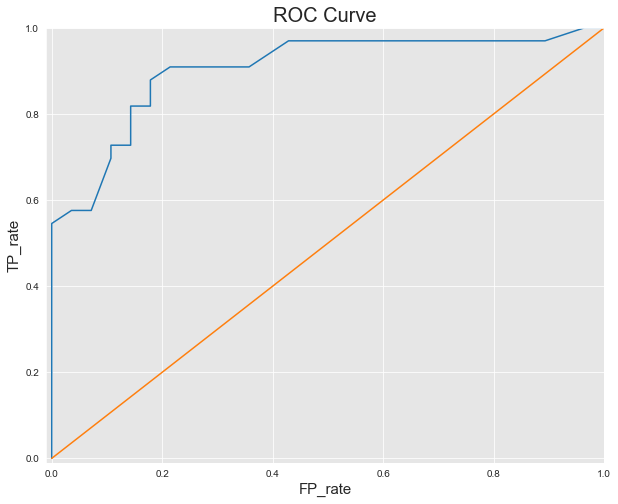

In [69]:
x_list = []
y_list = []

for x in np.linspace(0, 1, 100):
    
    # Same predictions based on predict_proba thresholds
    predicts = []
    
    for item in lr.predict_proba(X_test):
        if item[0] <= x:
            predicts.append(1)
        else:
            predicts.append(0)

    conf_matrix = pd.DataFrame(confusion_matrix(y_test, predicts), index = ['actual 0', 'actual 1'], 
                     columns = ['predicted 0', 'predicted 1'])
    
    
    # Assign TP, TN, FP, FN
    true_positives = conf_matrix['predicted 1'][1]
    true_negatives = conf_matrix['predicted 0'][0]
    false_positives = conf_matrix['predicted 1'][0]
    false_negatives = conf_matrix['predicted 0'][1]

    
    # Calculate Sensitivity and Specificity
    sensitivity = true_positives / (true_positives + false_negatives)

    specificity = true_negatives / (true_negatives + false_positives)
    
    
    # Append to lists to graph
    x_list.append(1 - specificity)

    y_list.append(sensitivity)

    
# Plot ROC curve

plt.figure(figsize = (10, 8))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('FP_rate', fontsize = 15)
plt.ylabel('TP_rate', fontsize = 15)
plt.xlim(-0.01, 1)
plt.ylim(-0.01, 1)
plt.plot(x_list, y_list);
plt.plot([0, 1], [0, 1]);

# x = 1 - specificity
# y = sensitivity

In [70]:
from sklearn.metrics import auc

In [71]:
auc(x_list, y_list)
# AUC: 0.9101731601731602

0.9036796536796536

### Let's add associated costs to our False Negatives and False Positives to our loop and minimize the cost
This is the naive way to optimize, but works well - you could also create a closed form optimization function

In [72]:
def my_eyes_cost_much(num_thres = 100, p_fp = 3, p_tn = 0.5, p_tp = 1, p_fn = 2):

    _thres = []; tpr = [] ; fpr = [] ; cost = []

    prediction = lr.predict_proba(X_test)

    ## Different code for same objective to calculate metrics at thresholds
    
    for thres in np.linspace(0.01, 1, num_thres):
        
        _thres.append(thres)
        predicts = np.zeros((prediction.shape[0], 1)) 
        predicts[np.where(prediction[:, 1] >= thres)] = 1

        conf_matrix = confusion_matrix(y_test, predicts)

        tp = conf_matrix[1, 1]
        tn = conf_matrix[0, 0]
        fp = conf_matrix[0, 1]
        fn = conf_matrix[1, 0]

        sensitivity = tp / (tp + fn)
        tnr = specificity = tn / (tn + fp)
        fnr = 1 - sensitivity

        tpr.append(sensitivity)
    
        fpr.append(1 - specificity)
        
        # add a cost function (this involves domain knowledge)
        
        current_cost = (p_fp * fp) + (p_tn * tn) + (p_tp * tp) + (p_fn * fn)
            
        cost.append(current_cost)  

    return fpr, tpr, cost, _thres

In [73]:
fpr, tpr, cost, thres = my_eyes_cost_much(num_thres = 100, p_fp = 3, p_tn = 0.5, p_tp = 1, p_fn = 2)

In [74]:
cost_idx = np.argmin(cost) # returns the minimum
min_cost_threshold = fpr[cost_idx], tpr[cost_idx], thres[cost_idx]

print(min_cost_threshold)

(0.0, 0.5757575757575758, 0.78)


In [75]:
np.argmin()

TypeError: argmin() missing 1 required positional argument: 'a'

Text(0.06, 0.5457575757575758, 'Threshold:0.78')

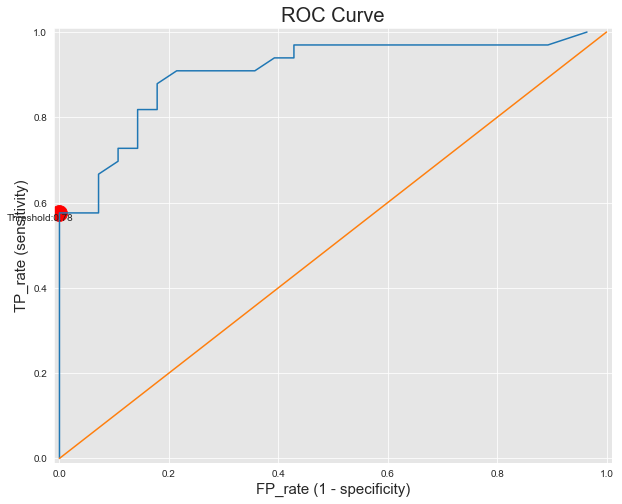

In [76]:
ax = plt.figure(figsize = (10, 8))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('FP_rate (1 - specificity)', fontsize = 15)
plt.ylabel('TP_rate (sensitivity)', fontsize = 15)
plt.xlim(-.01, 1.01)
plt.ylim(-.01, 1.01)
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1]);
plt.scatter(min_cost_threshold[0], min_cost_threshold[1], marker ='o', color = 'red', s=250)
ax.text(min_cost_threshold[0] + 0.06, min_cost_threshold[1] - 0.03, 'Threshold:'+ str(round(min_cost_threshold[2], 2)))


### Visualizing Threshold vs. Population Distribution

In [ ]:
import seaborn as sns

In [ ]:
lr.predict_proba(X_test)[:5]

In [ ]:
lr.predict(X_test)[:5]

In [ ]:
no_cancer_dist = []
cancer_dist = []

for item in lr.predict_proba(X_test):
    if item[0] <= .49:
        cancer_dist.append(item[0])
    else:
        no_cancer_dist.append(item[0])
        
plt.figure(figsize = (10, 6))
plt.title('Distributions of Patients with and without Cancer')
plt.xlabel('Threshold', fontsize = 14)

sns.distplot(no_cancer_dist, bins = 15, color = 'red')
sns.distplot(cancer_dist, bins = 15, color = 'blue')
plt.legend(['no cancer dist', 'cancer dist']);

### ROC curve vs Population Separation
![a](images/pop-curve.png)

![d](images/varying_dist_roc.png)

### Precision (Positive Predictive Value)

### $$ \frac{TP}{TP + FP}  $$

### F1 Score

### $$ 2 * \frac{\text{Precision * Recall}}{\text{Precision + Recall}} $$